## Final Project Submission
Please fill out:

* Student name: Guofa Shou
* Student pace: self paced
* Scheduled project review date/time:
* Instructor name:
* Blog post URL:

# Business Understanding
I firstly do the business understanding by the following questions and answers

In [818]:
# Q: Who are the stakeholders in this project? Who will be directly affected by the creation of this project?
# A: This project is try to develop a deep learning model that could dertermine whether a chest xray image is
#    belonging to a healthy person or a patient with pneumonia
# Q: What data sources are available to us?
# A: the images were downloaded from https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

# Data Understanding

Since I download the data from Kaggle.com, it has been already splitted into three folders.

How many images available for training, validation and test folders.

In [819]:
# General libraries
import os, shutil
import numpy as np
import pandas as pd 
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [820]:
# The data I loaded from the website has already been splitted into three subfolders
# holding the train, test and validation dataset
data_dir = 'chest_xray/'

train_folder = os.path.join(data_dir, 'train')
train_normal = os.path.join(train_folder, 'NORMAL')
train_pneumo = os.path.join(train_folder, 'PNEUMONIA')

test_folder = os.path.join(data_dir, 'test')
test_normal = os.path.join(test_folder, 'NORMAL')
test_pneumo = os.path.join(test_folder, 'PNEUMONIA')

val_folder = os.path.join(data_dir, 'val')
val_normal = os.path.join(val_folder, 'NORMAL')
val_pneumo = os.path.join(val_folder, 'PNEUMONIA')

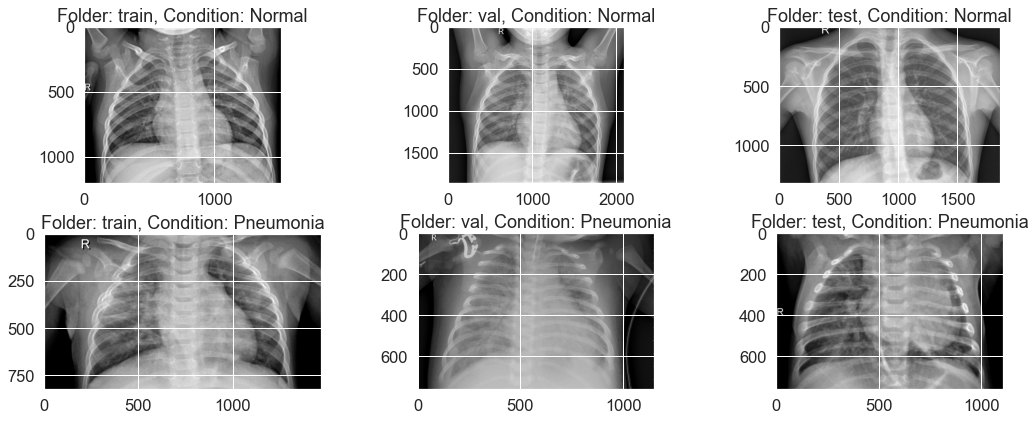

In [872]:
# Examine several images from two groups in different folder
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
ax = ax.ravel()
plt.tight_layout()
for i, folder in enumerate(['train', 'val', 'test']):
    set_path = data_dir + folder
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Folder: {}, Condition: Normal'.format(folder))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Folder: {}, Condition: Pneumonia'.format(folder))
    
plt.savefig('figures/xchestimage.png')

#### It's hard for a person to distinguish it is normal or pneumonia, and also the images seem have different dimensions

In [822]:
# Examining how many files in each folder: origial the validation folder only have 8 images for each group
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumo)), 'pneumonia images in the training set')
print('There are', len(os.listdir(test_normal)), 'normal images in the testing set')
print('There are', len(os.listdir(test_pneumo)), 'pneumonia images in the testing set')
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumo)), 'pneumonia images in the validation set')

There are 1191 normal images in the training set
There are 3725 pneumonia images in the training set
There are 234 normal images in the testing set
There are 390 pneumonia images in the testing set
There are 158 normal images in the validation set
There are 158 pneumonia images in the validation set


### It looks there are too few images in the validation set (i.e., 8 images) when I firstly download it from website, I will move 150 images for both categories from the training set to the validation set

In [823]:
# Moving 150 images for each group from the training set to the validation set,
# since it is too few images in the validation folder
if len(os.listdir(val_normal)) == 8:
    imgs_normal_train = [file for file in os.listdir(train_normal) if file.endswith('.jpeg')]
    imgs_pneumo_train = [file for file in os.listdir(train_pneumo) if file.endswith('.jpeg')]
    # move 150 images from training set to validation set
    imgs = imgs_normal_train[:150]
    for img in imgs:
        origin = os.path.join(train_normal, img)
        destination = os.path.join(val_normal, img)
        shutil.move(origin, destination)
    imgs = imgs_pneumo_train[:150]
    for img in imgs:
        origin = os.path.join(train_pneumo, img)
        destination = os.path.join(val_pneumo, img)
        shutil.move(origin, destination)  

   

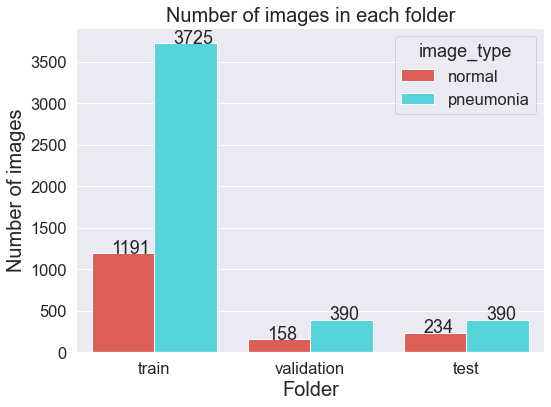

In [824]:
# How many files in each folder finally
d = {'image_type': ['normal', 'pneumonia','normal', 'pneumonia','normal', 'pneumonia'],
     'fold_type': ['train','train','validation','validation','test','test'],
     'num_image': [len(os.listdir(train_normal)), len(os.listdir(train_pneumo)),
                   len(os.listdir(val_normal)),   len(os.listdir(test_pneumo)),
                   len(os.listdir(test_normal)),  len(os.listdir(test_pneumo))]}
df = pd.DataFrame(data=d)
plt.subplots(figsize=(8,6))
sns.set(font_scale=1.5)
ax=sns.barplot(x = 'fold_type', y = 'num_image', hue = 'image_type', data = df,
            palette = 'hls',
            #order = ['normal', 'female'],  
            capsize = 0.05,             
            saturation = 8,
            errwidth=0)
#for i in ax.containers:
#    ax.bar_label(i,)
for ii in range(0,3):
     plt.text(ii-0.275,df['num_image'][ii*2+0],str(df['num_image'][ii*2+0]))
for ii in range(0,3):
     plt.text(ii+0.125,df['num_image'][ii*2+1],str(df['num_image'][ii*2+1]))    
plt.xlabel('Folder', fontsize = 20)
plt.ylabel('Number of images', fontsize = 20)
plt.title('Number of images in each folder',fontsize=20)
plt.tight_layout()
plt.savefig('figures/numimagesfinal.png')

# Image classification 

In [825]:
# Import necessary libraries
from keras.models import Model, Sequential
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score, confusion_matrix
np.random.seed(123)

In [826]:
# set global parameters
imgdim = 150 # resized dimension of images
epochs = 10  # number of epochs in the fitting
batchsize = 32 # batch size in the fitting

In [827]:
# Image data generator for different set and reshape them   
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(imgdim, imgdim),
        batch_size = len(os.listdir(train_normal))+len(os.listdir(train_pneumo)),
        class_mode='binary', 
        shuffle=True) 
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(imgdim, imgdim),
        batch_size = len(os.listdir(test_normal))+len(os.listdir(test_pneumo)),
        class_mode='binary', 
        shuffle=True) 
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(imgdim, imgdim),
        batch_size = len(os.listdir(val_normal))+len(os.listdir(val_pneumo)),
        class_mode='binary', 
        shuffle=True) 

Found 4916 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 316 images belonging to 2 classes.


In [828]:
# create the data sets for images and labels
train_images, train_labels = next(train_gen)
test_images, test_labels = next(test_gen)
val_images, val_labels = next(val_gen)

In [829]:
# Explore dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]
print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("Number of pixels: " + str(num_px))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 4916
Number of testing samples: 624
Number of validation samples: 316
Number of pixels: 150
train_images shape: (4916, 150, 150, 3)
train_labels shape: (4916,)
test_images shape: (624, 150, 150, 3)
test_labels shape: (624,)
val_images shape: (316, 150, 150, 3)
val_labels shape: (316,)


In [830]:
# reshape into 2 dimension for image data
train_img2D = train_images.reshape(train_images.shape[0], -1)
test_img2D = test_images.reshape(test_images.shape[0], -1)
val_img2D = val_images.reshape(val_images.shape[0], -1)
print(train_img2D.shape)
print(test_img2D.shape)
print(val_img2D.shape)

(4916, 67500)
(624, 67500)
(316, 67500)


## A baseline fully connected model: try differnt number of layers and number of nodes 

In [831]:
np.random.seed(123)
model_dense = Sequential()
model_dense.add(layers.Dense(20, activation='relu', input_shape=(imgdim*imgdim*3,))) 
model_dense.add(layers.Dense(16, activation='relu'))
model_dense.add(layers.Dense(5, activation='relu'))
model_dense.add(layers.Dense(1, activation='sigmoid'))
model_dense.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

In [832]:
history_dense = model_dense.fit(train_img2D,
                    train_labels,
                    epochs=epochs,
                    batch_size=batchsize,
                    validation_data=(val_img2D, val_labels))

Epoch 1/10
154/154 [==============================] - 3s 14ms/step - loss: 0.4734 - acc: 0.7604 - val_loss: 0.5047 - val_acc: 0.8354
Epoch 2/10
154/154 [==============================] - 2s 13ms/step - loss: 0.3435 - acc: 0.8672 - val_loss: 0.5040 - val_acc: 0.8101
Epoch 3/10
154/154 [==============================] - 2s 13ms/step - loss: 0.3006 - acc: 0.8851 - val_loss: 0.4549 - val_acc: 0.8481
Epoch 4/10
154/154 [==============================] - 2s 12ms/step - loss: 0.2685 - acc: 0.8969 - val_loss: 0.4855 - val_acc: 0.8323
Epoch 5/10
154/154 [==============================] - 2s 13ms/step - loss: 0.2531 - acc: 0.9095 - val_loss: 0.4587 - val_acc: 0.8386
Epoch 6/10
154/154 [==============================] - 2s 13ms/step - loss: 0.2288 - acc: 0.9225 - val_loss: 0.3742 - val_acc: 0.8734
Epoch 7/10
154/154 [==============================] - 2s 12ms/step - loss: 0.2038 - acc: 0.9349 - val_loss: 0.2668 - val_acc: 0.9367
Epoch 8/10
154/154 [==============================] - 2s 13ms/step - 

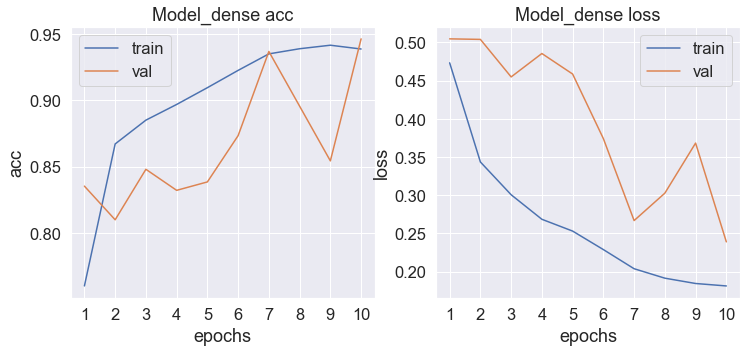

In [833]:
# visualization the history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.ravel()
for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(range(1,11),history_dense.history[met])
    ax[i].plot(range(1,11),history_dense.history['val_' + met])
    ax[i].set_title('Model_dense {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].set_xticks(range(1,11))
    ax[i].legend(['train', 'val'])  
plt.savefig('figures/model_dense_hist.png')

In [834]:
# Evaluate the model
results_train_dense = model_dense.evaluate(train_img2D, train_labels)
results_val_dense = model_dense.evaluate(val_img2D, val_labels)
results_test_dense = model_dense.evaluate(test_img2D, test_labels)
print('Results_train:{}'.format(np.round(results_train_dense,2)))
print('Results_val:{}'.format(np.round(results_val_dense,2)))
print('Results_test:{}'.format(np.round(results_test_dense,2)))

20/20 [==============================] - 0s 6ms/step - loss: 0.3968 - acc: 0.8253
Results_train:[0.26 0.91]
Results_val:[0.24 0.95]
Results_test:[0.4  0.83]


#### As a baseline fully connected model, it is not bad with the accuracy as 0.83

## CNN model with different settings

In [835]:
# Try different numbers of layers and numbers of filters
np.random.seed(123)
model_cnn = Sequential()
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', 
                             input_shape=(imgdim,imgdim,3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(32, (4, 4), activation='relu')) 
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
#model_cnn1.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model_cnn1.add(layers.MaxPooling2D((2, 2)))

model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='relu')) # 20
model_cnn.add(layers.Dense(16, activation='relu'))
model_cnn.add(layers.Dense(5, activation='relu'))
model_cnn.add(layers.Dense(1, activation='sigmoid'))
model_cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",#'adam',optimizers.RMSprop(lr=1e-4),# different optimization methods
              metrics=['acc'])

In [836]:
history_cnn = model_cnn.fit(train_images,
                    train_labels,
                    epochs=epochs,
                    batch_size=batchsize,
                    validation_data=(val_images, val_labels))

Epoch 1/10
154/154 [==============================] - 93s 599ms/step - loss: 0.5507 - acc: 0.7500 - val_loss: 0.6704 - val_acc: 0.5000
Epoch 2/10
154/154 [==============================] - 95s 614ms/step - loss: 0.4391 - acc: 0.7941 - val_loss: 0.6196 - val_acc: 0.6551
Epoch 3/10
154/154 [==============================] - 93s 602ms/step - loss: 0.3042 - acc: 0.8806 - val_loss: 0.5286 - val_acc: 0.7595
Epoch 4/10
154/154 [==============================] - 96s 627ms/step - loss: 0.2411 - acc: 0.9048 - val_loss: 0.2384 - val_acc: 0.8987
Epoch 5/10
154/154 [==============================] - 95s 617ms/step - loss: 0.1887 - acc: 0.9262 - val_loss: 0.1789 - val_acc: 0.9272
Epoch 6/10
154/154 [==============================] - 99s 644ms/step - loss: 0.1694 - acc: 0.9373 - val_loss: 0.2934 - val_acc: 0.8797
Epoch 7/10
154/154 [==============================] - 98s 637ms/step - loss: 0.1400 - acc: 0.9463 - val_loss: 0.2204 - val_acc: 0.9051
Epoch 8/10
154/154 [==============================] - 1

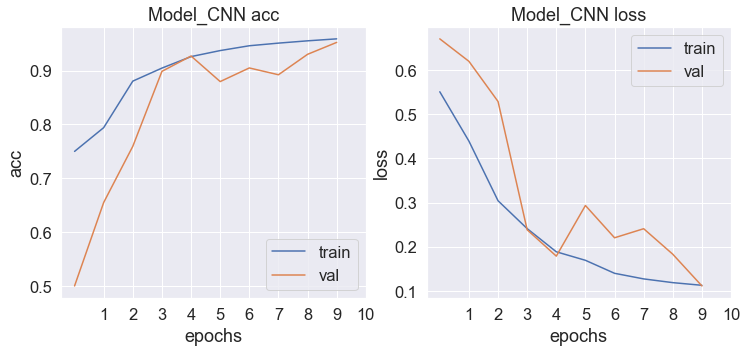

In [837]:
# visualization the history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.ravel()
for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_cnn.history[met])
    ax[i].plot(history_cnn.history['val_' + met])
    ax[i].set_title('Model_CNN {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)    
    ax[i].set_xticks(range(1,11))
    ax[i].legend(['train', 'val'])  
plt.savefig('figures/model_cnn_hist.png')

In [838]:
results_train_cnn = model_cnn.evaluate(train_images, train_labels)
results_val_cnn = model_cnn.evaluate(val_images, val_labels)
results_test_cnn = model_cnn.evaluate(test_images, test_labels)
print('Results_train:{}'.format(np.round(results_train_cnn,2)))
print('Results_val:{}'.format(np.round(results_val_cnn,2)))
print('Results_test:{}'.format(np.round(results_test_cnn,2)))

20/20 [==============================] - 2s 107ms/step - loss: 0.6371 - acc: 0.7965
Results_train:[0.12 0.96]
Results_val:[0.11 0.95]
Results_test:[0.64 0.8 ]


#### A little increase from the dense model

### Try Data Augmentation

In [839]:
train_datagenAug1 = ImageDataGenerator(rescale=1./255, 
                                   zoom_range=0.3, 
                                   vertical_flip=True)
                                   #rotation_range=40, 
                                   #width_shift_range=0.2, 
                                   #height_shift_range=0.2, 
                                   #shear_range=0.3, 
                                   #zoom_range=0.1, 
                                   #horizontal_flip=False,
                                   #fill_mode='nearest')

In [840]:
# get all the data in the directory test , and reshape them
test_gen1 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(imgdim, imgdim), 
        batch_size = batchsize,
        class_mode='binary',
        shuffle = True) 

# get all the data in the directory validation, and reshape them
val_gen1 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(imgdim, imgdim),
        batch_size = batchsize,
        class_mode='binary',
        shuffle=True)

# get all the data in the directory train, and reshape them
train_gen1 = train_datagenAug1.flow_from_directory(
        train_folder, 
        target_size=(imgdim, imgdim), 
        batch_size = batchsize, 
        class_mode='binary',
        shuffle=True)

Found 624 images belonging to 2 classes.
Found 316 images belonging to 2 classes.
Found 4916 images belonging to 2 classes.


In [841]:
# use the same cnn model but with different train_gen
np.random.seed(123)
model_cnnda = model_cnn
model_cnnda.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])
model_cnnda.summary()

Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_148 (Conv2D)         (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_148 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_149 (Conv2D)         (None, 71, 71, 32)        16416     
                                                                 
 max_pooling2d_149 (MaxPooli  (None, 35, 35, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_150 (Conv2D)         (None, 33, 33, 64)        18496     
                                                                 
 max_pooling2d_150 (MaxPooli  (None, 16, 16, 64)     

In [842]:
history_cnnda = model_cnnda.fit(train_gen1, 
                    steps_per_epoch=train_gen1.samples // batchsize,
                    epochs=epochs, 
                    validation_data=val_gen1, 
                    validation_steps=val_gen1.samples // batchsize)

Epoch 1/10
153/153 [==============================] - 187s 1s/step - loss: 0.3591 - acc: 0.8538 - val_loss: 0.1838 - val_acc: 0.9514
Epoch 2/10
153/153 [==============================] - 168s 1s/step - loss: 0.2995 - acc: 0.8761 - val_loss: 0.2189 - val_acc: 0.9132
Epoch 3/10
153/153 [==============================] - 165s 1s/step - loss: 0.2678 - acc: 0.8903 - val_loss: 0.2563 - val_acc: 0.9062
Epoch 4/10
153/153 [==============================] - 170s 1s/step - loss: 0.2419 - acc: 0.9052 - val_loss: 0.3220 - val_acc: 0.8403
Epoch 5/10
153/153 [==============================] - 165s 1s/step - loss: 0.2335 - acc: 0.9038 - val_loss: 0.2200 - val_acc: 0.9132
Epoch 6/10
153/153 [==============================] - 165s 1s/step - loss: 0.2146 - acc: 0.9138 - val_loss: 0.2404 - val_acc: 0.8958
Epoch 7/10
153/153 [==============================] - 168s 1s/step - loss: 0.2082 - acc: 0.9232 - val_loss: 0.3183 - val_acc: 0.8542
Epoch 8/10
153/153 [==============================] - 166s 1s/step - 

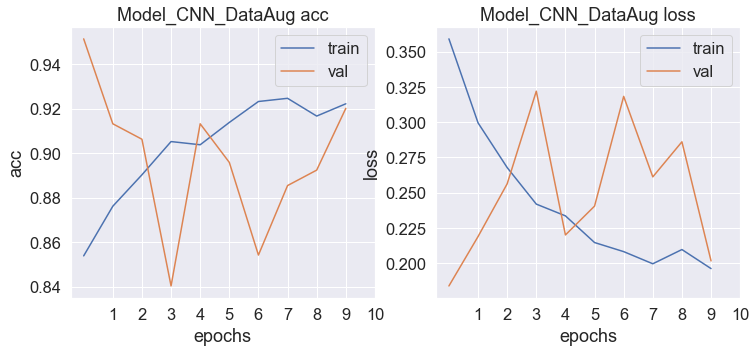

In [843]:
# Visualization of history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.ravel()
for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_cnnda.history[met])
    ax[i].plot(history_cnnda.history['val_' + met])
    ax[i].set_title('Model_CNN_DataAug {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)    
    ax[i].set_xticks(range(1,11))
    ax[i].legend(['train', 'val'])  
plt.savefig('figures/model_cnnda_hist.png')

In [844]:
results_train_cnnda = model_cnnda.evaluate(train_gen1)
results_val_cnnda = model_cnnda.evaluate(val_gen1)
results_test_cnnda = model_cnnda.evaluate(test_gen1)
print('Results_train:{}'.format(np.round(results_train_cnnda,2)))
print('Results_val:{}'.format(np.round(results_val_cnnda,2)))
print('Results_test:{}'.format(np.round(results_test_cnnda,2)))

20/20 [==============================] - 9s 471ms/step - loss: 0.3838 - acc: 0.8814
Results_train:[0.18 0.93]
Results_val:[0.21 0.91]
Results_test:[0.38 0.88]


### Try BatchNormalization

In [845]:
np.random.seed(123)
model_cnnbn = Sequential()
model_cnnbn.add(layers.Conv2D(32, (3, 3), activation='relu', 
                             input_shape=(imgdim,imgdim,3)))
model_cnnbn.add(layers.MaxPooling2D((2, 2)))

model_cnnbn.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_cnnbn.add(layers.BatchNormalization())
model_cnnbn.add(layers.MaxPooling2D((2, 2)))

model_cnnbn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnnbn.add(layers.BatchNormalization())
model_cnnbn.add(layers.MaxPooling2D((2, 2)))

model_cnnbn.add(layers.Flatten())
model_cnnbn.add(layers.Dense(64, activation='relu'))
model_cnnbn.add(layers.Dense(16, activation='relu'))
model_cnnbn.add(layers.Dense(5, activation='relu'))
model_cnnbn.add(layers.Dense(1, activation='sigmoid'))

model_cnnbn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

history_cnnbn = model_cnnbn.fit(train_generator, 
                    steps_per_epoch=train_gen1.samples // batchsize,
                    epochs=epochs, 
                    validation_data=val_gen1, 
                    validation_steps=val_gen1.samples // batchsize)


Epoch 1/10
153/153 [==============================] - 177s 1s/step - loss: 0.3655 - acc: 0.8284 - val_loss: 0.8352 - val_acc: 0.5035
Epoch 2/10
153/153 [==============================] - 172s 1s/step - loss: 0.2497 - acc: 0.8946 - val_loss: 1.9168 - val_acc: 0.4931
Epoch 3/10
153/153 [==============================] - 174s 1s/step - loss: 0.2145 - acc: 0.9138 - val_loss: 0.8841 - val_acc: 0.6528
Epoch 4/10
153/153 [==============================] - 177s 1s/step - loss: 0.1991 - acc: 0.9226 - val_loss: 0.1889 - val_acc: 0.9410
Epoch 5/10
153/153 [==============================] - 171s 1s/step - loss: 0.1969 - acc: 0.9197 - val_loss: 2.0233 - val_acc: 0.5000
Epoch 6/10
153/153 [==============================] - 172s 1s/step - loss: 0.1991 - acc: 0.9187 - val_loss: 0.2308 - val_acc: 0.9271
Epoch 7/10
153/153 [==============================] - 174s 1s/step - loss: 0.1770 - acc: 0.9285 - val_loss: 0.7011 - val_acc: 0.6701
Epoch 8/10
153/153 [==============================] - 174s 1s/step - 

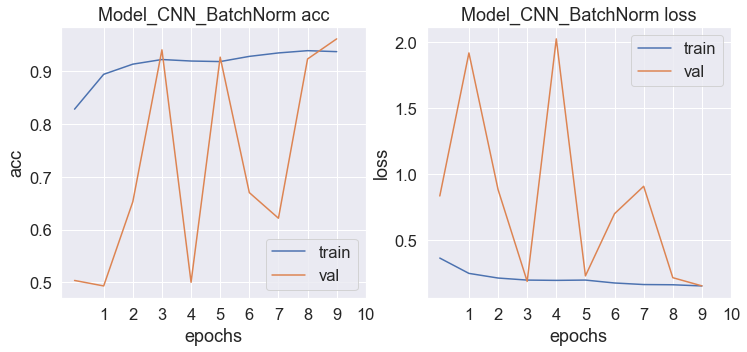

In [846]:
# Visualization of history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.ravel()
for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_cnnbn.history[met])
    ax[i].plot(history_cnnbn.history['val_' + met])
    ax[i].set_title('Model_CNN_BatchNorm {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)    
    ax[i].set_xticks(range(1,11))
    ax[i].legend(['train', 'val'])  
plt.savefig('figures/model_cnnbn_hist.png')

In [847]:
results_train_cnnbn = model_cnnbn.evaluate(train_generator)
results_val_cnnbn = model_cnnbn.evaluate(val_generator)
results_test_cnnbn = model_cnnbn.evaluate(test_generator)
print('Results_train:{}'.format(np.round(results_train_cnnbn,2)))
print('Results_val:{}'.format(np.round(results_val_cnnbn,2)))
print('Results_test:{}'.format(np.round(results_test_cnnbn,2)))

20/20 [==============================] - 10s 519ms/step - loss: 0.2541 - acc: 0.8974
Results_train:[0.17 0.94]
Results_val:[0.15 0.96]
Results_test:[0.25 0.9 ]


### The use of Batchnormalization improved accuracy

### Try Dropout

In [873]:
np.random.seed(123)
model_cnndo = Sequential()
model_cnndo.add(layers.Conv2D(32, (3, 3), activation='relu', 
                             input_shape=(imgdim,imgdim,3)))
model_cnndo.add(layers.MaxPooling2D((2, 2)))

model_cnndo.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_cnndo.add(layers.BatchNormalization())
model_cnndo.add(layers.MaxPooling2D((2, 2)))

model_cnndo.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnndo.add(layers.BatchNormalization())
model_cnndo.add(layers.MaxPooling2D((2, 2)))
model_cnndo.add(layers.Dropout(rate=0.2))

model_cnndo.add(layers.Flatten())
model_cnndo.add(layers.Dense(64, activation='relu'))
model_cnndo.add(layers.Dense(16, activation='relu'))
model_cnndo.add(layers.Dense(5, activation='relu'))
model_cnndo.add(layers.Dense(1, activation='sigmoid'))

model_cnndo.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

history_cnndo = model_cnndo.fit(train_gen1, 
                    steps_per_epoch=train_gen1.samples // batchsize,
                    epochs=epochs, 
                    validation_data=val_gen1, 
                    validation_steps=val_gen1.samples // batchsize)

Epoch 1/10
153/153 [==============================] - 185s 1s/step - loss: 0.3312 - acc: 0.8544 - val_loss: 0.7707 - val_acc: 0.4931
Epoch 2/10
153/153 [==============================] - 184s 1s/step - loss: 0.2444 - acc: 0.8958 - val_loss: 0.9349 - val_acc: 0.4931
Epoch 3/10
153/153 [==============================] - 184s 1s/step - loss: 0.2081 - acc: 0.9158 - val_loss: 1.6985 - val_acc: 0.5312
Epoch 4/10
153/153 [==============================] - 183s 1s/step - loss: 0.1929 - acc: 0.9208 - val_loss: 1.8164 - val_acc: 0.5764
Epoch 5/10
153/153 [==============================] - 183s 1s/step - loss: 0.1818 - acc: 0.9257 - val_loss: 0.2429 - val_acc: 0.9028
Epoch 6/10
153/153 [==============================] - 182s 1s/step - loss: 0.1799 - acc: 0.9275 - val_loss: 0.4028 - val_acc: 0.8125
Epoch 7/10
153/153 [==============================] - 187s 1s/step - loss: 0.1694 - acc: 0.9287 - val_loss: 0.6841 - val_acc: 0.7674
Epoch 8/10
153/153 [==============================] - 183s 1s/step - 

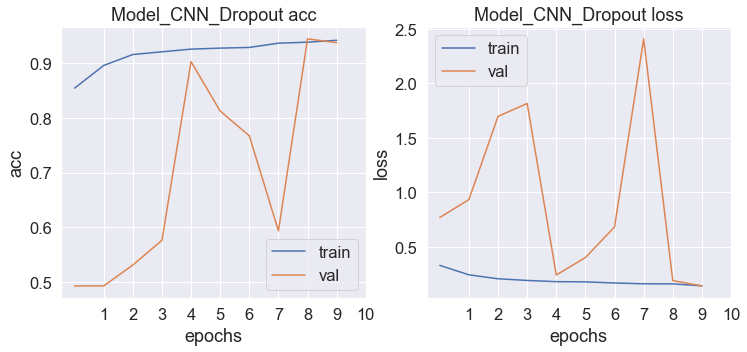

In [874]:
# Visualization of history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.ravel()
for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_cnndo.history[met])
    ax[i].plot(history_cnndo.history['val_' + met])
    ax[i].set_title('Model_CNN_Dropout {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)    
    ax[i].set_xticks(range(1,11))
    ax[i].legend(['train', 'val'])  
plt.savefig('figures/model_cnndo_hist.png')

In [875]:
#results_train_cnndo = model_cnndo.evaluate(train_gen1)
results_val_cnndo = model_cnndo.evaluate(val_gen1)
results_test_cnndo = model_cnndo.evaluate(test_gen1)

#print('Results_train:{}'.format(np.round(results_train_cnndo,2)))
print('Results_val:{}'.format(np.round(results_val_cnndo,2)))
print('Results_test:{}'.format(np.round(results_test_cnndo,2)))

20/20 [==============================] - 10s 518ms/step - loss: 0.3022 - acc: 0.8974
Results_val:[0.14 0.94]
Results_test:[0.3 0.9]


### The use of dropout decrease the accuracy

### Try pretraining model: VGG19

In [851]:
from tensorflow.keras.applications import VGG19
vgg19_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(imgdim, imgdim, 3))

In [852]:
# The model
vgg19_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [853]:
# cnn model with vgg19 + dense model
np.random.seed(123)
model_cnnvgg0 = Sequential()
model_cnnvgg0.add(vgg19_base)
model_cnnvgg0.add(layers.Flatten())
model_cnnvgg0.add(layers.Dense(64, activation='relu'))
model_cnnvgg0.add(layers.Dense(16, activation='relu'))
model_cnnvgg0.add(layers.Dense(5, activation='relu'))
model_cnnvgg0.add(layers.Dense(1, activation='sigmoid'))
vgg19_base.trainable = False
for layer in model_cnnvgg0.layers:
    print(layer.name, layer.trainable) 
    
model_cnnvgg0.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history_cnnvgg0 = model_cnnvgg0.fit(train_gen1, 
                    steps_per_epoch=train_gen1.samples // batchsize,
                    epochs=epochs, 
                    validation_data=val_gen1, 
                    validation_steps=val_gen1.samples // batchsize)

vgg19 False
flatten_81 True
dense_389 True
dense_390 True
dense_391 True
dense_392 True
Epoch 1/10
153/153 [==============================] - 404s 3s/step - loss: 0.3653 - acc: 0.7643 - val_loss: 0.4415 - val_acc: 0.6806
Epoch 2/10
153/153 [==============================] - 408s 3s/step - loss: 0.2963 - acc: 0.8776 - val_loss: 0.4324 - val_acc: 0.9444
Epoch 3/10
153/153 [==============================] - 405s 3s/step - loss: 0.2686 - acc: 0.9068 - val_loss: 0.2757 - val_acc: 0.9514
Epoch 4/10
153/153 [==============================] - 402s 3s/step - loss: 0.2171 - acc: 0.9140 - val_loss: 0.2233 - val_acc: 0.9340
Epoch 5/10
153/153 [==============================] - 402s 3s/step - loss: 0.1944 - acc: 0.9249 - val_loss: 0.2366 - val_acc: 0.9410
Epoch 6/10
153/153 [==============================] - 367s 2s/step - loss: 0.1843 - acc: 0.9263 - val_loss: 0.1931 - val_acc: 0.9444
Epoch 7/10
153/153 [==============================] - 377s 2s/step - loss: 0.1808 - acc: 0.9271 - val_loss: 0.1712

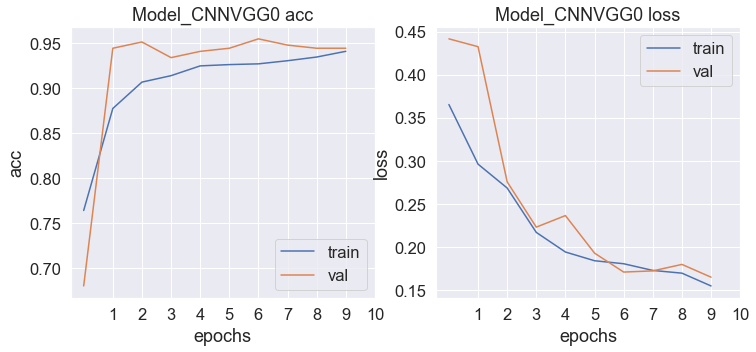

In [854]:
# visualization the history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.ravel()
for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_cnnvgg0.history[met])
    ax[i].plot(history_cnnvgg0.history['val_' + met])
    ax[i].set_title('Model_CNNVGG0 {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)    
    ax[i].set_xticks(range(1,11))
    ax[i].legend(['train', 'val'])  
plt.savefig('figures/model_cnnvgg0_hist.png')

In [855]:
results_train_cnnvgg0 = model_cnnvgg0.evaluate(train_gen1)
results_val_cnnvgg0 = model_cnnvgg0.evaluate(val_gen1)
results_test_cnnvgg0 = model_cnnvgg0.evaluate(test_gen1)

print('Results_train:{}'.format(np.round(results_train_cnnvgg0,2)))
print('Results_val:{}'.format(np.round(results_val_cnnvgg0,2)))
print('Results_test:{}'.format(np.round(results_test_cnnvgg0,2)))

20/20 [==============================] - 45s 2s/step - loss: 0.2815 - acc: 0.9006
Results_train:[0.16 0.94]
Results_val:[0.16 0.95]
Results_test:[0.28 0.9 ]


In [856]:
# cnn model with vgg19 + dense model with more layers and number of nodes
np.random.seed(123)
model_cnnvgg1 = Sequential()
model_cnnvgg1.add(vgg19_base)
model_cnnvgg1.add(layers.Flatten())
model_cnnvgg1.add(layers.Dense(64, activation='relu'))
model_cnnvgg1.add(layers.Dense(128, activation='relu'))
model_cnnvgg1.add(layers.Dense(256, activation='relu'))
model_cnnvgg1.add(layers.Dense(16, activation='relu'))
model_cnnvgg1.add(layers.Dense(1, activation='sigmoid'))
vgg19_base.trainable = False
for layer in model_cnnvgg1.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_82 True
dense_393 True
dense_394 True
dense_395 True
dense_396 True
dense_397 True


In [857]:
model_cnnvgg1.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history_cnnvgg1 = model_cnnvgg1.fit(train_gen1, 
                    steps_per_epoch=train_gen1.samples // batchsize,
                    epochs=epochs, 
                    validation_data=val_gen1, 
                    validation_steps=val_gen1.samples // batchsize)

Epoch 1/10
153/153 [==============================] - 400s 3s/step - loss: 0.3288 - acc: 0.8530 - val_loss: 0.2286 - val_acc: 0.9444
Epoch 2/10
153/153 [==============================] - 374s 2s/step - loss: 0.2305 - acc: 0.9064 - val_loss: 0.1758 - val_acc: 0.9444
Epoch 3/10
153/153 [==============================] - 393s 3s/step - loss: 0.1966 - acc: 0.9144 - val_loss: 0.1430 - val_acc: 0.9618
Epoch 4/10
153/153 [==============================] - 346s 2s/step - loss: 0.1878 - acc: 0.9232 - val_loss: 0.1565 - val_acc: 0.9444
Epoch 5/10
153/153 [==============================] - 361s 2s/step - loss: 0.1799 - acc: 0.9271 - val_loss: 0.1906 - val_acc: 0.9479
Epoch 6/10
153/153 [==============================] - 382s 2s/step - loss: 0.1727 - acc: 0.9298 - val_loss: 0.1776 - val_acc: 0.9340
Epoch 7/10
153/153 [==============================] - 433s 3s/step - loss: 0.1717 - acc: 0.9326 - val_loss: 0.1573 - val_acc: 0.9618
Epoch 8/10
153/153 [==============================] - 425s 3s/step - 

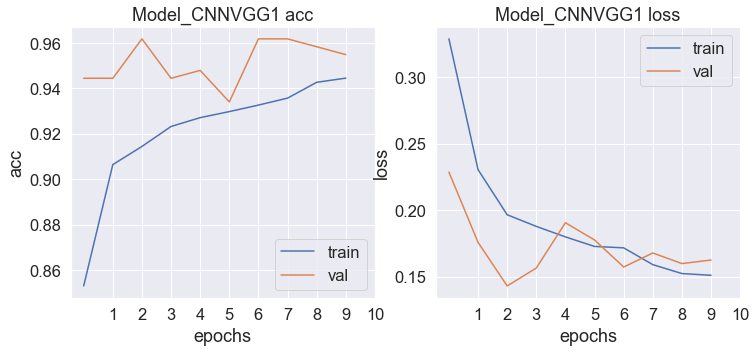

In [858]:
# visualization the history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.ravel()
for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_cnnvgg1.history[met])
    ax[i].plot(history_cnnvgg1.history['val_' + met])
    ax[i].set_title('Model_CNNVGG1 {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)    
    ax[i].set_xticks(range(1,11))
    ax[i].legend(['train', 'val'])  
plt.savefig('figures/model_cnnvgg1_hist.png')

In [859]:
results_train_cnnvgg1 = model_cnnvgg1.evaluate(train_gen1)
results_val_cnnvgg1 = model_cnnvgg1.evaluate(val_gen1)
results_test_cnnvgg1 = model_cnnvgg1.evaluate(test_gen1)

print('Results_train:{}'.format(np.round(results_train_cnnvgg1,2)))
print('Results_val:{}'.format(np.round(results_val_cnnvgg1,2)))
print('Results_test:{}'.format(np.round(results_test_cnnvgg1,2)))

20/20 [==============================] - 47s 2s/step - loss: 0.3116 - acc: 0.9054
Results_train:[0.13 0.95]
Results_val:[0.15 0.96]
Results_test:[0.31 0.91]


In [860]:
# Try another data augmentation
train_datagen2 = ImageDataGenerator(rescale=1./255,                                    
                                   vertical_flip=True,
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False,
                                   fill_mode='nearest')
                            
# get all the data in the directory train, and reshape them
train_gen2 = train_datagen2.flow_from_directory(
        train_folder, 
        target_size=(imgdim, imgdim), 
        batch_size = batchsize, 
        class_mode='binary',
        shuffle=True)

Found 4916 images belonging to 2 classes.


In [861]:
# use the same model as cnnvgg0
np.random.seed(123)
model_cnnvgg0da2 = Sequential()
model_cnnvgg0da2.add(vgg19_base)
model_cnnvgg0da2.add(layers.Flatten())
model_cnnvgg0da2.add(layers.Dense(64, activation='relu'))
model_cnnvgg0da2.add(layers.Dense(16, activation='relu'))
model_cnnvgg0da2.add(layers.Dense(5, activation='relu'))
model_cnnvgg0da2.add(layers.Dense(1, activation='sigmoid'))
vgg19_base.trainable = False
for layer in model_cnnvgg0da2.layers:
    print(layer.name, layer.trainable)    

model_cnnvgg0da2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
    
history_cnnvgg0da2 = model_cnnvgg0da2.fit(train_gen2, 
                    steps_per_epoch=train_gen2.samples // batchsize,
                    epochs=epochs, 
                    validation_data=val_gen1, 
                    validation_steps=val_gen1.samples // batchsize)

vgg19 False
flatten_83 True
dense_398 True
dense_399 True
dense_400 True
dense_401 True


C:\Users\guofa shou\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/10
153/153 [==============================] - 417s 3s/step - loss: 0.6931 - acc: 0.5905 - val_loss: 0.6318 - val_acc: 0.7708
Epoch 2/10
153/153 [==============================] - 407s 3s/step - loss: 0.6672 - acc: 0.8194 - val_loss: 0.5851 - val_acc: 0.9167
Epoch 3/10
153/153 [==============================] - 396s 3s/step - loss: 0.6500 - acc: 0.8423 - val_loss: 0.5422 - val_acc: 0.9271
Epoch 4/10
153/153 [==============================] - 389s 3s/step - loss: 0.6342 - acc: 0.8651 - val_loss: 0.5086 - val_acc: 0.9410
Epoch 5/10
153/153 [==============================] - 394s 3s/step - loss: 0.6262 - acc: 0.8753 - val_loss: 0.5159 - val_acc: 0.9410
Epoch 6/10
153/153 [==============================] - 381s 2s/step - loss: 0.6128 - acc: 0.8853 - val_loss: 0.4840 - val_acc: 0.9479
Epoch 7/10
153/153 [==============================] - 394s 3s/step - loss: 0.6032 - acc: 0.8941 - val_loss: 0.4549 - val_acc: 0.9653
Epoch 8/10
153/153 [==============================] - 391s 3s/step - 

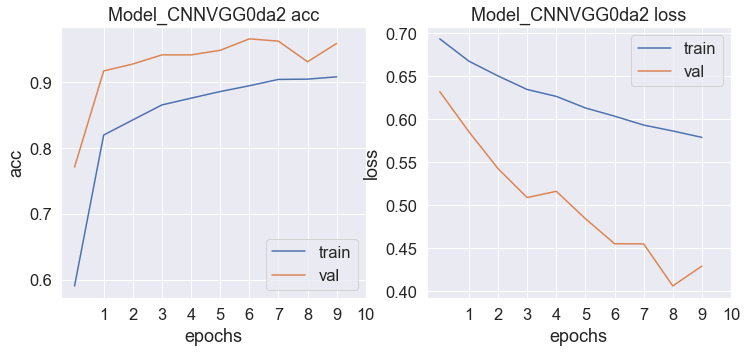

In [862]:
# visualization the history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.ravel()
for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_cnnvgg0da2.history[met])
    ax[i].plot(history_cnnvgg0da2.history['val_' + met])
    ax[i].set_title('Model_CNNVGG0da2 {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)    
    ax[i].set_xticks(range(1,11))
    ax[i].legend(['train', 'val'])  
plt.savefig('figures/model_cnnvgg0da2_hist.png')

In [863]:
#results_train_cnnvgg0da2 = model_cnnvgg0da2.evaluate(train_gen2)
results_val_cnnvgg0da2 = model_cnnvgg0da2.evaluate(val_gen1)
results_test_cnnvgg0da2 = model_cnnvgg0da2.evaluate(test_gen1)

#print('Results_train:{}'.format(np.round(results_train_cnnvgg0da2,2)))
print('Results_val:{}'.format(np.round(results_val_cnnvgg0da2,2)))
print('Results_test:{}'.format(np.round(results_test_cnnvgg0da2,2)))


20/20 [==============================] - 55s 3s/step - loss: 0.5536 - acc: 0.8942
Results_val:[0.43 0.96]
Results_test:[0.55 0.89]


In [864]:
np.random.seed(123)
model_cnnvgg1da2 = Sequential()
model_cnnvgg1da2.add(vgg19_base)
model_cnnvgg1da2.add(layers.Flatten())
model_cnnvgg1da2.add(layers.Dense(64, activation='relu'))
model_cnnvgg1da2.add(layers.Dense(128, activation='relu'))
model_cnnvgg1da2.add(layers.Dense(256, activation='relu'))
model_cnnvgg1da2.add(layers.Dense(16, activation='relu'))
model_cnnvgg1da2.add(layers.Dense(1, activation='sigmoid'))
vgg19_base.trainable = False
for layer in model_cnnvgg1da2.layers:
    print(layer.name, layer.trainable)

model_cnnvgg1da2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
history_cnnvgg1da2 = model_cnnvgg1da2.fit(train_gen2, 
                    steps_per_epoch=train_gen2.samples // batchsize,
                    epochs=epochs, 
                    validation_data=val_gen1, 
                    validation_steps=val_gen1.samples // batchsize)

vgg19 False
flatten_84 True
dense_402 True
dense_403 True
dense_404 True
dense_405 True
dense_406 True
Epoch 1/10
153/153 [==============================] - 424s 3s/step - loss: 0.3503 - acc: 0.8403 - val_loss: 0.2880 - val_acc: 0.9097
Epoch 2/10
153/153 [==============================] - 418s 3s/step - loss: 0.2555 - acc: 0.8857 - val_loss: 0.1944 - val_acc: 0.9479
Epoch 3/10
153/153 [==============================] - 441s 3s/step - loss: 0.2314 - acc: 0.9048 - val_loss: 0.1708 - val_acc: 0.9306
Epoch 4/10
153/153 [==============================] - 443s 3s/step - loss: 0.2111 - acc: 0.9118 - val_loss: 0.1885 - val_acc: 0.9340
Epoch 5/10
153/153 [==============================] - 407s 3s/step - loss: 0.2000 - acc: 0.9214 - val_loss: 0.1441 - val_acc: 0.9549
Epoch 6/10
153/153 [==============================] - 434s 3s/step - loss: 0.1972 - acc: 0.9181 - val_loss: 0.1707 - val_acc: 0.9410
Epoch 7/10
153/153 [==============================] - 383s 2s/step - loss: 0.1848 - acc: 0.9214 - v

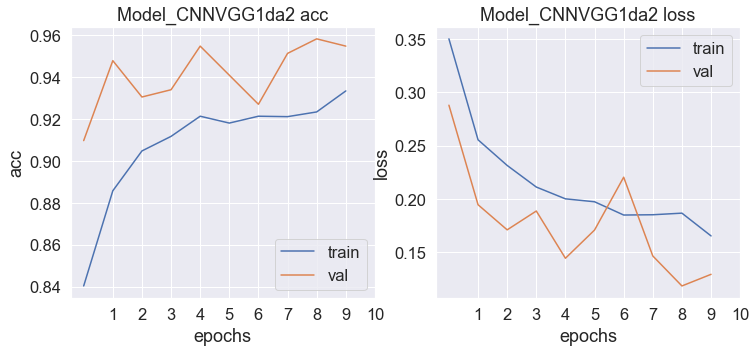

In [865]:
# visualization the history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.ravel()
for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_cnnvgg1da2.history[met])
    ax[i].plot(history_cnnvgg1da2.history['val_' + met])
    ax[i].set_title('Model_CNNVGG1da2 {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)    
    ax[i].set_xticks(range(1,11))
    ax[i].legend(['train', 'val'])  
plt.savefig('figures/model_cnnvgg1da2_hist.png')

In [866]:
results_train_cnnvgg1da2 = model_cnnvgg1da2.evaluate(train_gen2)
results_val_cnnvgg1da2 = model_cnnvgg1da2.evaluate(val_gen1)
results_test_cnnvgg1da2 = model_cnnvgg1da2.evaluate(test_gen1)

print('Results_train:{}'.format(np.round(results_train_cnnvgg1da2,2)))
print('Results_val:{}'.format(np.round(results_val_cnnvgg1da2,2)))
print('Results_test:{}'.format(np.round(results_test_cnnvgg1da2,2)))

20/20 [==============================] - 47s 2s/step - loss: 0.2983 - acc: 0.9054
Results_train:[0.16 0.93]
Results_val:[0.13 0.96]
Results_test:[0.3  0.91]


## Final Model Evaluation 

In [880]:
# Accuracy for different trained models
test_lossall = list()
test_accall = list()
modelnames = list()
test_loss, test_acc = model_dense.evaluate(test_img2D,test_labels)
test_lossall.append(test_loss), test_accall.append(test_acc), modelnames.append('model_dense')

test_loss, test_acc = model_cnn.evaluate(test_images,test_labels)
test_lossall.append(test_loss),test_accall.append(test_acc), modelnames.append('model_cnn')

test_loss, test_acc = model_cnnda.evaluate(test_images,test_labels)
test_lossall.append(test_loss),test_accall.append(test_acc), modelnames.append('model_cnnda')

test_loss, test_acc = model_cnnbn.evaluate(test_images,test_labels)
test_lossall.append(test_loss),test_accall.append(test_acc), modelnames.append('model_cnnbn')

test_loss, test_acc = model_cnndo.evaluate(test_images,test_labels)
test_lossall.append(test_loss),test_accall.append(test_acc), modelnames.append('model_cnndo')

test_loss, test_acc = model_cnnvgg0.evaluate(test_images,test_labels)
test_lossall.append(test_loss),test_accall.append(test_acc), modelnames.append('model_cnnvgg0')

test_loss, test_acc = model_cnnvgg0da2.evaluate(test_images,test_labels)
test_lossall.append(test_loss),test_accall.append(test_acc), modelnames.append('model_cnnvgg0da2')

test_loss, test_acc = model_cnnvgg1.evaluate(test_images,test_labels)
test_lossall.append(test_loss),test_accall.append(test_acc), modelnames.append('model_cnnvgg1')

test_loss, test_acc = model_cnnvgg1da2.evaluate(test_images,test_labels)
test_lossall.append(test_loss),test_accall.append(test_acc), modelnames.append('model_cnnvgg1da2')

20/20 [==============================] - 50s 3s/step - loss: 0.2983 - acc: 0.9054


(None, None, None)

In [881]:
testlossaccdf = pd.DataFrame()
testlossaccdf['model_name'] = modelnames
testlossaccdf['test_loss'] = np.round(test_lossall,3)
testlossaccdf['test_acc'] = np.round(test_accall,3)
testlossaccdf['model_name0'] = [x[6:] for x in testlossaccdf['model_name']]
testlossaccdf

,model_name,test_loss,test_acc,model_name0
0,model_dense,0.397,0.825,dense
1,model_cnn,0.384,0.881,cnn
2,model_cnnda,0.384,0.881,cnnda
3,model_cnnbn,0.254,0.897,cnnbn
4,model_cnndo,0.302,0.897,cnndo
5,model_cnnvgg0,0.282,0.901,cnnvgg0
6,model_cnnvgg0da2,0.554,0.894,cnnvgg0da2
7,model_cnnvgg1,0.312,0.905,cnnvgg1
8,model_cnnvgg1da2,0.298,0.905,cnnvgg1da2


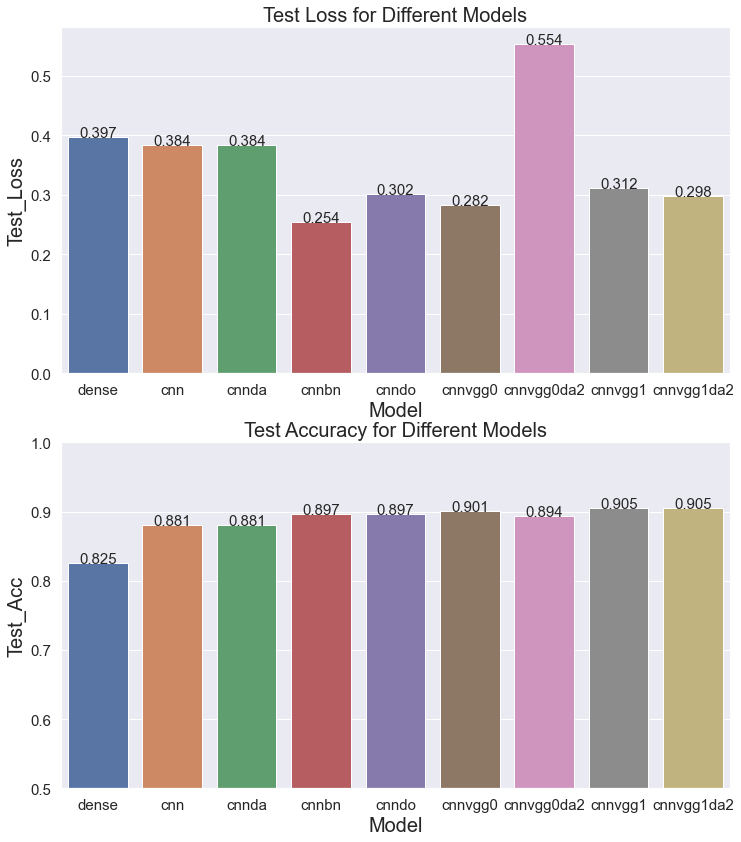

In [882]:
# Visualization of accuracy and loss for different models
fig, ax = plt.subplots(2, 1, figsize=(12, 14))
sns.barplot(x = 'model_name0', y = 'test_loss', data = testlossaccdf, ax = ax[0])
ax[0].set_title('Test Loss for Different Models', fontsize = 20)
ax[0].tick_params(axis = 'both', labelsize = 15)
ax[0].set_xlabel('Model', fontsize = 20)
ax[0].set_ylabel('Test_Loss', fontsize = 20,)
for ii in range(0,len(testlossaccdf['test_loss'])):
    ax[0].text(ii-0.25,testlossaccdf['test_loss'][ii],str(testlossaccdf['test_loss'][ii]),fontsize=15)
sns.barplot(x = 'model_name0', y = 'test_acc', data = testlossaccdf, ax = ax[1])
for ii in range(0,len(testlossaccdf['test_acc'])):
    ax[1].text(ii-0.25,testlossaccdf['test_acc'][ii],str(testlossaccdf['test_acc'][ii]),fontsize=15)
ax[1].set_title('Test Accuracy for Different Models', fontsize = 20)
ax[1].tick_params(axis = 'both', labelsize = 15)
ax[1].set_xlabel('Model', fontsize = 20)
ax[1].set_ylabel('Test_Acc', fontsize = 20,)
ax[1].set_ylim(0.5,1.0)
plt.savefig('figures/modelcomp_testlossacc.png')

### It seems that the cnnvgg models are slight better, while they are generally similar

In [887]:
# I chose cnnvgg0da2 to visualization confusion matrix
preds = model_cnnvgg1.predict(test_images)

In [899]:
acc = accuracy_score(test_labels, np.round(preds))*100
confmat = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = confmat.ravel()
print('-------- CONFUSION MATRIX ------------------')
print(confmat)

print('\n ------------- TEST METRICS ----------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confmat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confmat.flatten()/np.sum(confmat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

-------- CONFUSION MATRIX ------------------
[[183  51]
 [  8 382]]

 ------------- TEST METRICS ----------------
Accuracy: 90.5448717948718%
Precision: 88.2217090069284%
Recall: 97.94871794871794%
F1-score: 92.83110571081409


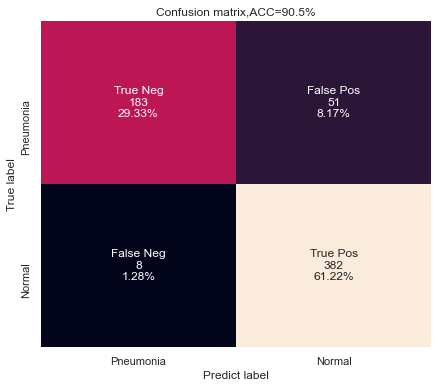

In [898]:
plt.figure(figsize = (7,6))
sns.heatmap(confmat,annot=labels,fmt='',xticklabels=['Pneumonia','Normal'],yticklabels=['Pneumonia','Normal'],cbar=False)
plt.ylabel('True label')
plt.xlabel('Predict label')
plt.title('Confusion matrix'+',ACC='+"{}".format(round(acc,1))+'%')
plt.savefig('figures/FinalModel_conf.png')

## It achieves above 90% accuracy.
## With more adjustment and more data, the accuracy could be further improved

In [889]:
model_cnnvgg1.summary()

Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_82 (Flatten)        (None, 8192)              0         
                                                                 
 dense_393 (Dense)           (None, 64)                524352    
                                                                 
 dense_394 (Dense)           (None, 128)               8320      
                                                                 
 dense_395 (Dense)           (None, 256)               33024     
                                                                 
 dense_396 (Dense)           (None, 16)                4112      
                                                                 
 dense_397 (Dense)           (None, 1)              